# Economic Trend Analysis (2000–2024)

This project explores key economic indicators such as GDP, Federal Funds Rate, S&P500, Median CPI, and Unemployment Rate. 

### **Goals:**
1. Clean and preprocess the data.
2. Perform exploratory data analysis (EDA).
3. Build predictive and clustering models.
4. Develop visualizations for insights and trends.
5. Present a comprehensive operational dashboard.

## Import Libraries and Load Data

In [99]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA


In [100]:
# Define file paths for datasets
files = {
    "Federal_Funds_Rate": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\Federal Funds Effective Rate.csv",
    "GDP": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\GDP.csv",
    "Median_CPI": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\Median CPI.csv",
    "S&P500": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\sp500 yahoo.csv",
    "Unemployment_Rate": r"C:\Users\AKKem\OneDrive\Desktop\Data Analysis Modules\Projects\Economic_Trend_Analysis\Resources\unemployment_rate.csv"
}

# Load datasets into a dictionary of DataFrames
datasets = {name: pd.read_csv(path) for name, path in files.items()}

# Display dataset information
for name, df in datasets.items():
    print(f"\n{name} Dataset:")
    print(df.info())



Federal_Funds_Rate Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8767 entries, 0 to 8766
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    8767 non-null   object 
 1   DFF     8767 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.1+ KB
None

GDP Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DATE    97 non-null     object 
 1   GDP     97 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None

Median_CPI Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   DATE               289 non-null    object 
 1   MEDCPIM158SFRBCLE  289 non-null    float64
dtypes: float64(1), 

In [101]:
# Rename columns for consistency
datasets["Federal_Funds_Rate"] = datasets["Federal_Funds_Rate"].rename(columns={"DFF": "FEDERAL_FUNDS_RATE"})
datasets["GDP"] = datasets["GDP"].rename(columns={"GDP": "GROSS_DOMESTIC_PRODUCT"})
datasets["Median_CPI"] = datasets["Median_CPI"].rename(columns={"MEDCPIM158SFRBCLE": "MEDIAN_CPI"})
datasets["S&P500"] = datasets["S&P500"].rename(columns={"Close": "SP500_CLOSE"})
datasets["Unemployment_Rate"] = datasets["Unemployment_Rate"].rename(columns={"UNRATE": "UNEMPLOYMENT_RATE"})

In [111]:
# Remove commas and convert SP500_CLOSE to numeric
merged_df['SP500_CLOSE'] = merged_df['SP500_CLOSE'].str.replace(',', '').astype(float)


In [112]:
# Standardize column names and clean data
for name, df in datasets.items():
    df.columns = df.columns.str.upper().str.strip()
    if 'DATE' in df.columns:
        df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
    df.interpolate(method='linear', inplace=True)
    df.fillna(method='bfill', inplace=True)
    df.fillna(method='ffill', inplace=True)


### Save Cleaned Data into SQLite



In [113]:
# Save cleaned datasets into SQLite database
conn = sqlite3.connect('Economic_Analysis.db')

for name, df in datasets.items():
    table_name = name.replace(" ", "_").replace("&", "_").upper()  # Sanitize table names
    df.to_sql(table_name, conn, if_exists='replace', index=False)
    print(f"Saved {table_name} to SQLite database.")

# Verify saved tables
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

Saved FEDERAL_FUNDS_RATE to SQLite database.
Saved GDP to SQLite database.
Saved MEDIAN_CPI to SQLite database.
Saved S_P500 to SQLite database.
Saved UNEMPLOYMENT_RATE to SQLite database.
                 name
0              S&P500
1  FEDERAL_FUNDS_RATE
2                 GDP
3          MEDIAN_CPI
4              S_P500
5   UNEMPLOYMENT_RATE


## Merge Data for Analysis

In [114]:
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)


                 name
0              S&P500
1  FEDERAL_FUNDS_RATE
2                 GDP
3          MEDIAN_CPI
4              S_P500
5   UNEMPLOYMENT_RATE


In [146]:
query = '''
    SELECT 
        a.DATE,
        a.FEDERAL_FUNDS_RATE,
        b.GROSS_DOMESTIC_PRODUCT,
        c.MEDIAN_CPI,
        d.SP500_CLOSE,
        e.UNEMPLOYMENT_RATE
    FROM FEDERAL_FUNDS_RATE a
    JOIN GDP b ON a.DATE = b.DATE
    JOIN MEDIAN_CPI c ON a.DATE = c.DATE
    JOIN S_P500 d ON a.DATE = d.DATE
    JOIN UNEMPLOYMENT_RATE e ON a.DATE = e.DATE
'''

# Load the merged dataset into a DataFrame
merged_df = pd.read_sql_query(query, conn)
print(merged_df.info())

# Ensure DATE column is in datetime format
merged_df['DATE'] = pd.to_datetime(merged_df['DATE'], errors='coerce')

# Preview the merged data
print(merged_df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DATE                    48 non-null     object 
 1   FEDERAL_FUNDS_RATE      48 non-null     float64
 2   GROSS_DOMESTIC_PRODUCT  48 non-null     float64
 3   MEDIAN_CPI              48 non-null     float64
 4   SP500_CLOSE             48 non-null     object 
 5   UNEMPLOYMENT_RATE       48 non-null     float64
dtypes: float64(4), object(2)
memory usage: 2.4+ KB
None
        DATE  FEDERAL_FUNDS_RATE  GROSS_DOMESTIC_PRODUCT  MEDIAN_CPI  \
0 2001-10-01                3.02               10660.465    4.184077   
1 2002-04-01                1.88               10887.460    2.676482   
2 2002-07-01                1.83               10984.040    2.245055   
3 2002-10-01                1.85               11061.433    2.313903   
4 2003-04-01                1.29               11312.766 

## Exploratory Data Analysis (EDA)


In [147]:
# Display summary statistics
print(merged_df.describe())


                      DATE  FEDERAL_FUNDS_RATE  GROSS_DOMESTIC_PRODUCT  \
count                   48           48.000000               48.000000   
mean   2012-03-01 05:00:00            0.989583            16823.184187   
min    2001-10-01 00:00:00            0.060000            10660.465000   
25%    2007-03-09 12:00:00            0.107500            14071.587500   
50%    2012-02-15 00:00:00            0.265000            16034.049500   
75%    2017-01-22 12:00:00            1.852500            19153.340250   
max    2022-07-01 00:00:00            4.920000            26272.011000   
std                    NaN            1.139817             4256.683574   

       MEDIAN_CPI  UNEMPLOYMENT_RATE  
count   48.000000          48.000000  
mean     2.567626           6.422917  
min      0.125833           3.500000  
25%      1.982906           5.075000  
50%      2.359403           5.800000  
75%      2.920364           7.375000  
max      6.923883          14.800000  
std      1.354605    

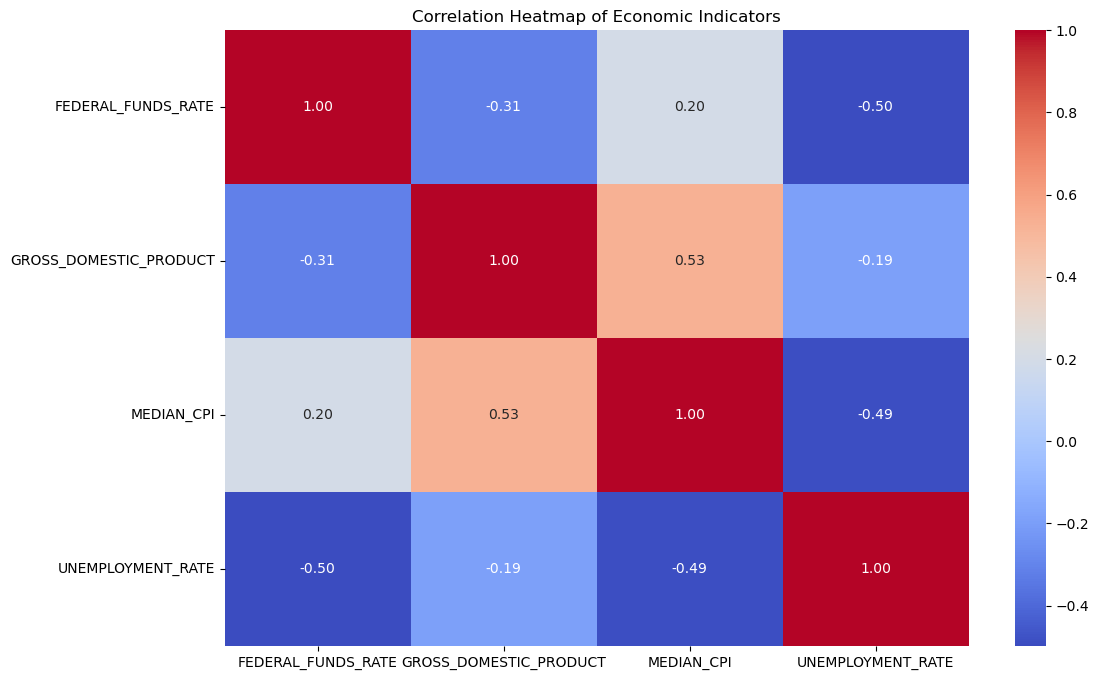

In [148]:
# Exclude non-numeric columns
numeric_data = merged_df.select_dtypes(include=[np.number])

# Plot correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Economic Indicators")
plt.show()



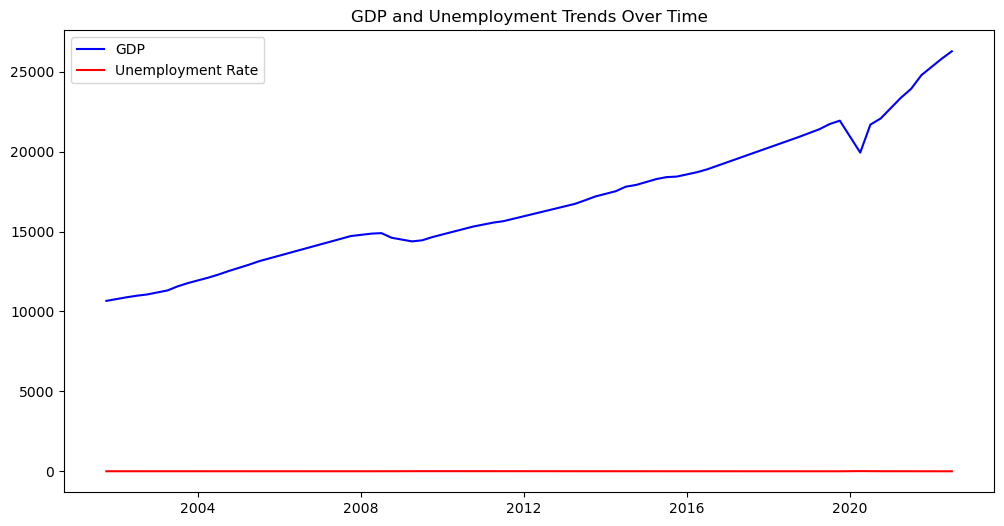

In [149]:
# GDP and Unemployment Trends
plt.figure(figsize=(12, 6))
plt.plot(merged_df['DATE'], merged_df['GROSS_DOMESTIC_PRODUCT'], label='GDP', color='blue')
plt.plot(merged_df['DATE'], merged_df['UNEMPLOYMENT_RATE'], label='Unemployment Rate', color='red')
plt.title("GDP and Unemployment Trends Over Time")
plt.legend()
plt.show()


## Predictive Modeling 

In [150]:
# Convert SP500_CLOSE to numeric
merged_df['SP500_CLOSE'] = merged_df['SP500_CLOSE'].str.replace(',', '').astype(float)

# Features and Target
X = merged_df[['FEDERAL_FUNDS_RATE', 'MEDIAN_CPI', 'SP500_CLOSE', 'UNEMPLOYMENT_RATE']]
y = merged_df['GROSS_DOMESTIC_PRODUCT']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Evaluate Model
y_pred = rf_model.predict(X_test)
print("Mean Absolute Error:", mean_absolute_error(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, y_pred)))


Mean Absolute Error: 730.4860329999987
Mean Squared Error: 972057.7777332697
Root Mean Squared Error: 985.9299050811218


## Clustering Analysis

C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


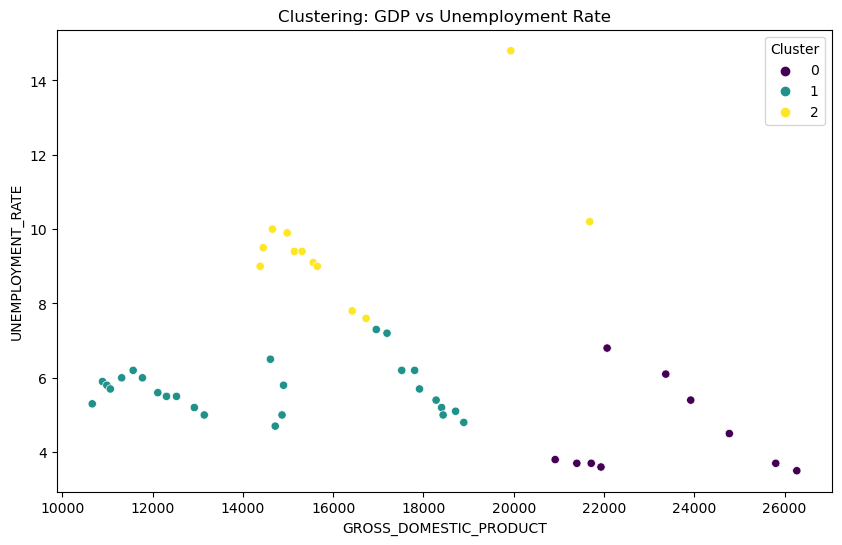

In [151]:
# Scale Data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(merged_df[['GROSS_DOMESTIC_PRODUCT', 'UNEMPLOYMENT_RATE', 'SP500_CLOSE']])

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged_df['Cluster'] = kmeans.fit_predict(scaled_data)

# Scatter Plot for Clustering
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_df, x='GROSS_DOMESTIC_PRODUCT', y='UNEMPLOYMENT_RATE', hue='Cluster', palette='viridis')
plt.title("Clustering: GDP vs Unemployment Rate")
plt.show()


## Financial Forecasting

In [152]:
## ARIMA Forecasting for GDP
# ARIMA Model
gdp_series = merged_df.set_index('DATE')['GROSS_DOMESTIC_PRODUCT']
model = ARIMA(gdp_series, order=(1, 1, 1))
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=12)
print("GDP Forecast for Next Year:", forecast)

GDP Forecast for Next Year: 48    26594.398067
49    26916.782940
50    27239.165619
51    27561.546105
52    27883.924398
53    28206.300497
54    28528.674402
55    28851.046114
56    29173.415633
57    29495.782958
58    29818.148089
59    30140.511028
Name: predicted_mean, dtype: float64


C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.

## Step 8: Budget and Economic Indicator Analysis


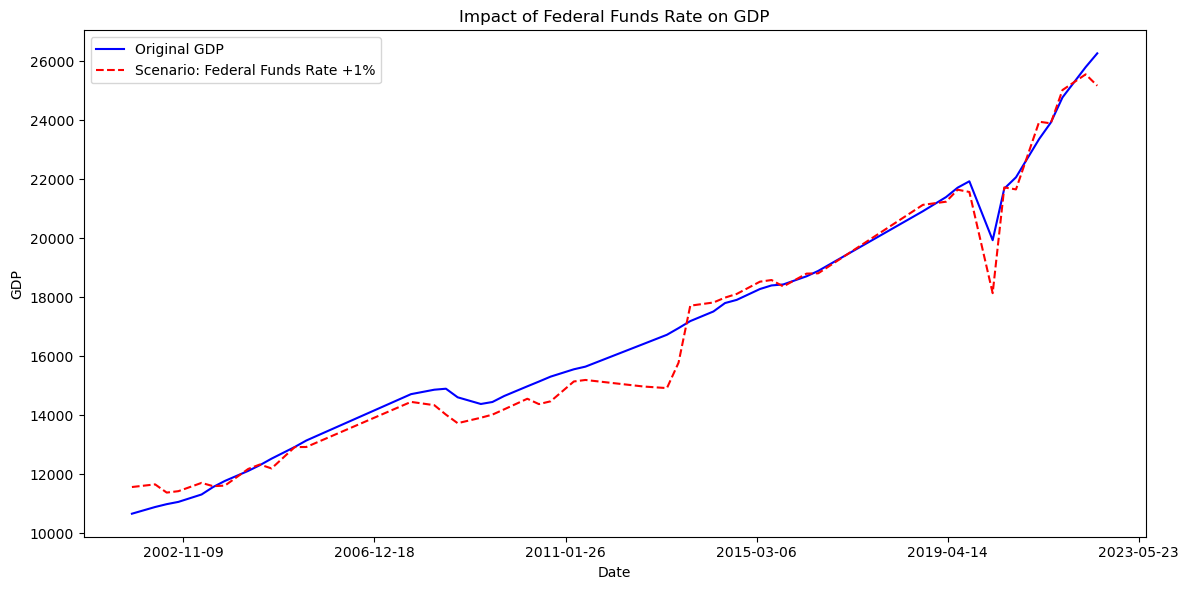

In [154]:
# Budget Scenarios
scenario = merged_df.copy()
scenario['FEDERAL_FUNDS_RATE'] += 1  # Simulate 1% increase
scenario_pred = rf_model.predict(scenario[['FEDERAL_FUNDS_RATE', 'MEDIAN_CPI', 'SP500_CLOSE', 'UNEMPLOYMENT_RATE']])

# Compare Scenarios
plt.figure(figsize=(12, 6))
plt.plot(merged_df['DATE'], merged_df['GROSS_DOMESTIC_PRODUCT'], label='Original GDP', color='blue')
plt.plot(merged_df['DATE'], scenario_pred, label='Scenario: Federal Funds Rate +1%', linestyle='--', color='red')

# Formatting the x-axis for minimal ticks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Set a maximum of 6 x-axis ticks

plt.title("Impact of Federal Funds Rate on GDP")
plt.xlabel("Date")
plt.ylabel("GDP")
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()




## Rolling Correlation Analysis

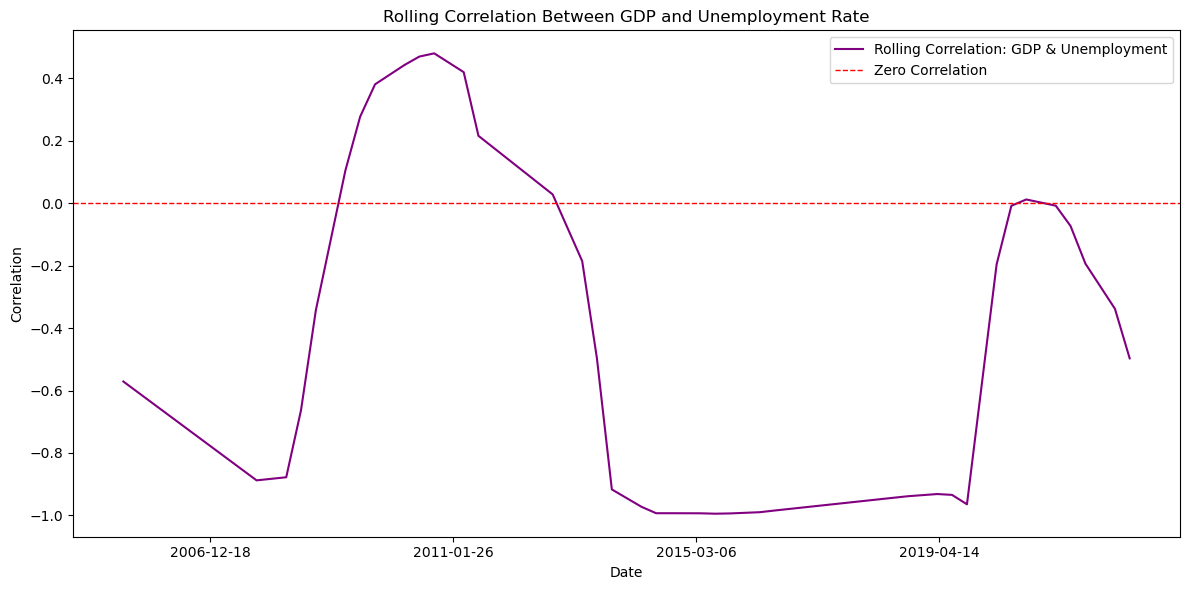

In [155]:
# Calculate rolling correlation between GDP and Unemployment Rate
merged_df['GDP_UNEMPLOYMENT_ROLLING_CORR'] = merged_df['GROSS_DOMESTIC_PRODUCT'].rolling(window=12).corr(merged_df['UNEMPLOYMENT_RATE'])

# Plot Rolling Correlation
plt.figure(figsize=(12, 6))
plt.plot(merged_df['DATE'], merged_df['GDP_UNEMPLOYMENT_ROLLING_CORR'], label="Rolling Correlation: GDP & Unemployment", color='purple')
plt.axhline(0, linestyle='--', color='red', linewidth=1, label='Zero Correlation')

# Formatting the x-axis for minimal ticks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Set a maximum of 6 x-axis ticks

plt.title("Rolling Correlation Between GDP and Unemployment Rate")
plt.xlabel("Date")
plt.ylabel("Correlation")
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



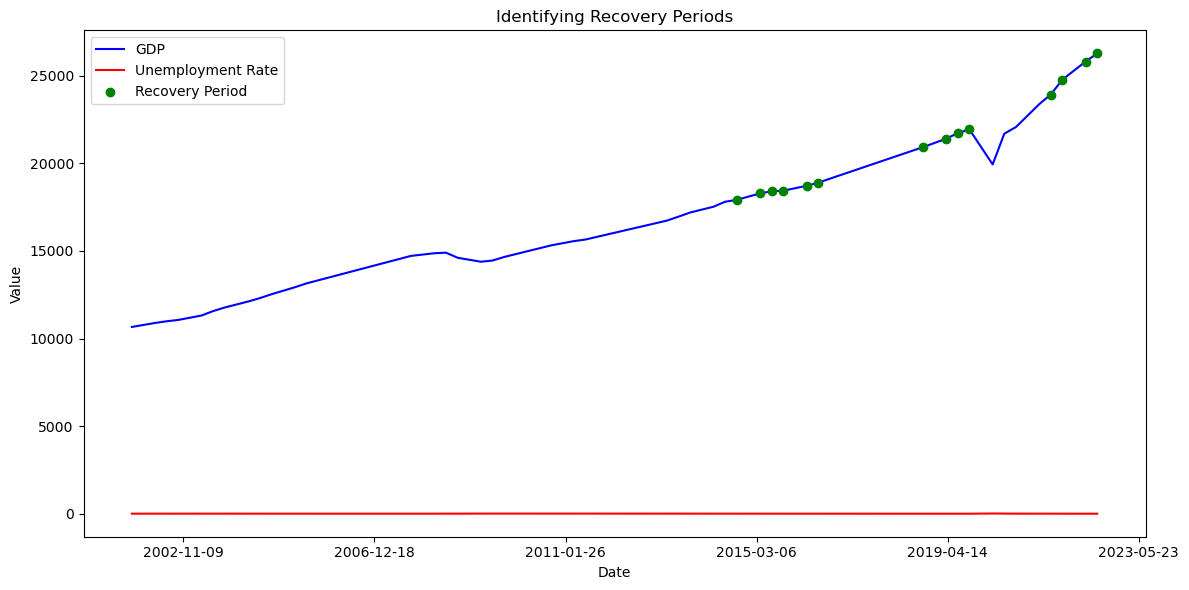

In [156]:
# Highlight periods of recovery
recovery_periods = merged_df[(merged_df['UNEMPLOYMENT_RATE'] < 6) & (merged_df['GROSS_DOMESTIC_PRODUCT'] > 15000)]

# Plot GDP and Unemployment for recovery analysis
plt.figure(figsize=(12, 6))
plt.plot(merged_df['DATE'], merged_df['GROSS_DOMESTIC_PRODUCT'], label='GDP', color='blue')
plt.plot(merged_df['DATE'], merged_df['UNEMPLOYMENT_RATE'], label='Unemployment Rate', color='red')
plt.scatter(recovery_periods['DATE'], recovery_periods['GROSS_DOMESTIC_PRODUCT'], color='green', label='Recovery Period', zorder=5)

# Formatting the x-axis for minimal ticks
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(6))  # Set a maximum of 6 x-axis ticks

plt.title("Identifying Recovery Periods")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()



## Operational Dashboard Components

C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\AKKem\anaconda3\envs\dev\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


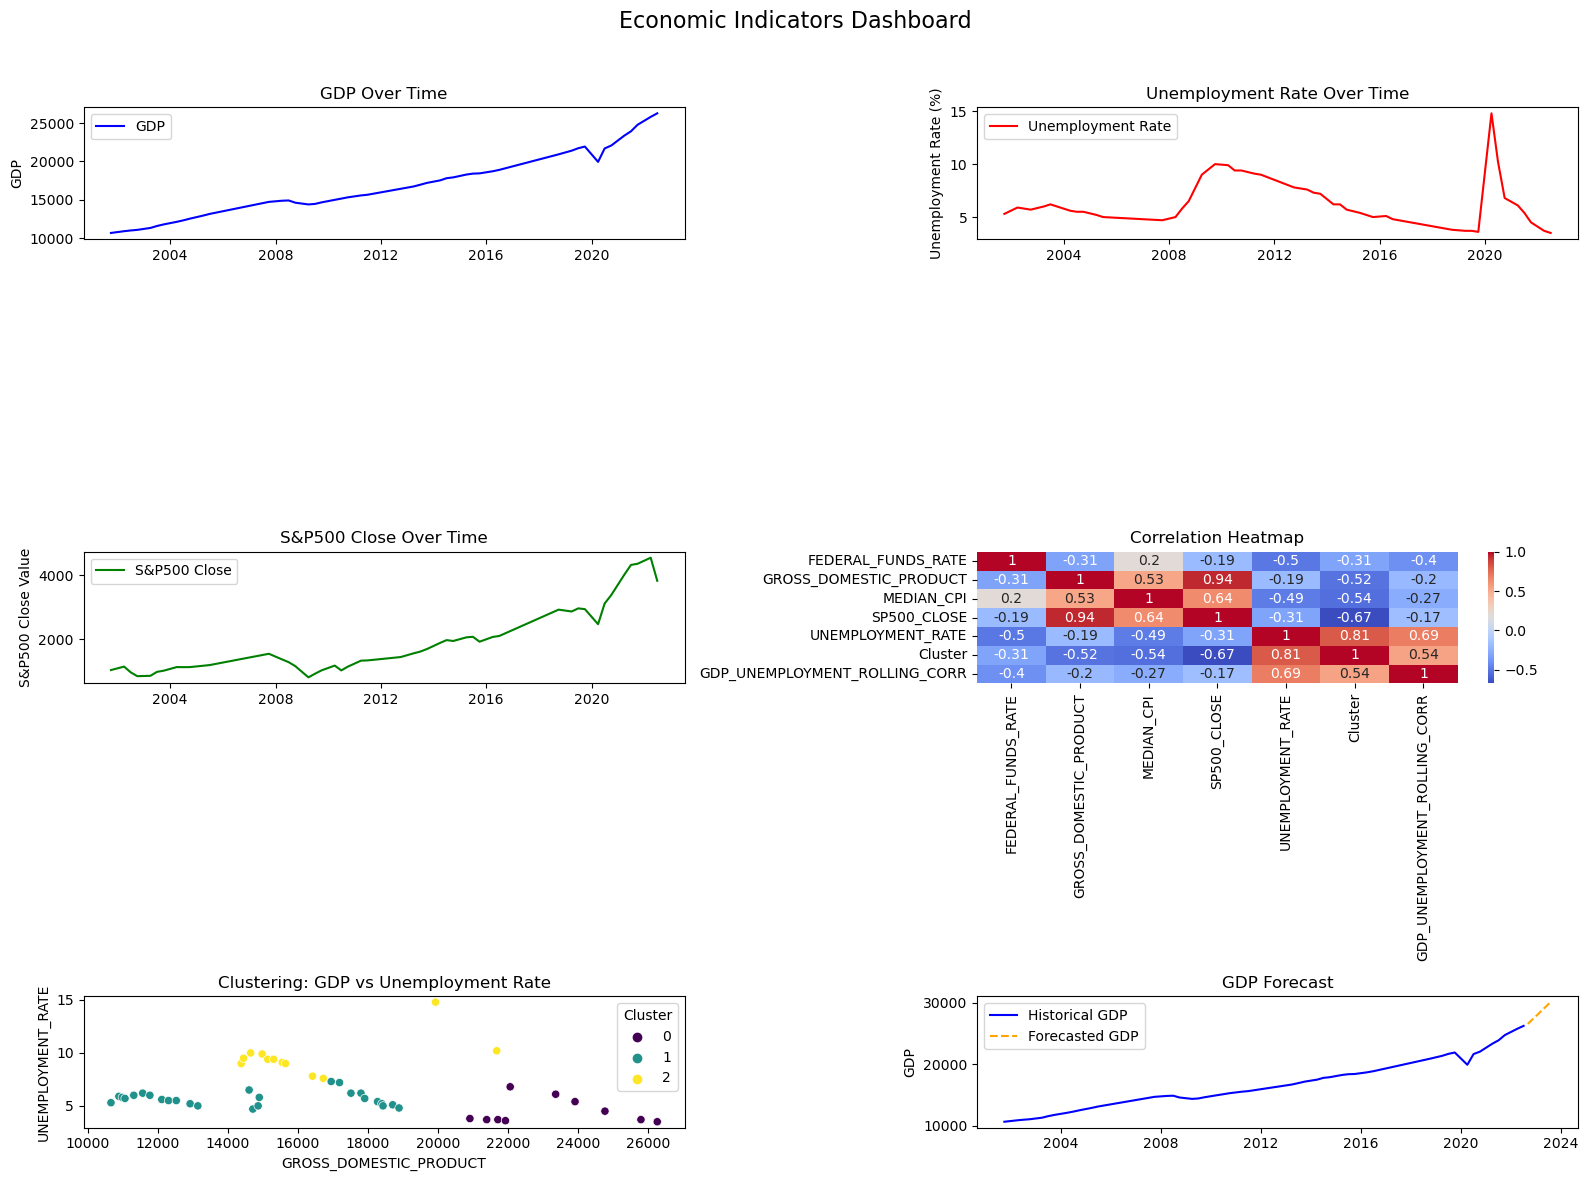

In [135]:
# Create a dashboard with multiple subplots
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle("Economic Indicators Dashboard", fontsize=16)

# GDP Over Time
axes[0, 0].plot(pd.to_datetime(merged_df['DATE']), merged_df['GROSS_DOMESTIC_PRODUCT'], label='GDP', color='blue')
axes[0, 0].set_title("GDP Over Time")
axes[0, 0].set_ylabel("GDP")
axes[0, 0].legend()

# Unemployment Rate Over Time
axes[0, 1].plot(pd.to_datetime(merged_df['DATE']), merged_df['UNEMPLOYMENT_RATE'], label='Unemployment Rate', color='red')
axes[0, 1].set_title("Unemployment Rate Over Time")
axes[0, 1].set_ylabel("Unemployment Rate (%)")
axes[0, 1].legend()

# S&P500 Close Over Time
axes[1, 0].plot(pd.to_datetime(merged_df['DATE']), merged_df['SP500_CLOSE'], label='S&P500 Close', color='green')
axes[1, 0].set_title("S&P500 Close Over Time")
axes[1, 0].set_ylabel("S&P500 Close Value")
axes[1, 0].legend()

# Correlation Heatmap
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm', ax=axes[1, 1])
axes[1, 1].set_title("Correlation Heatmap")

# Clustering Visualization
sns.scatterplot(data=merged_df, x='GROSS_DOMESTIC_PRODUCT', y='UNEMPLOYMENT_RATE', hue='Cluster', palette='viridis', ax=axes[2, 0])
axes[2, 0].set_title("Clustering: GDP vs Unemployment Rate")

# Financial Forecast
forecasted_dates = pd.date_range(start=pd.to_datetime(merged_df['DATE']).max(), periods=13, freq='M')[1:]
forecast_gdp = model_fit.forecast(len(forecasted_dates))
axes[2, 1].plot(pd.to_datetime(merged_df['DATE']), merged_df['GROSS_DOMESTIC_PRODUCT'], label='Historical GDP', color='blue')
axes[2, 1].plot(forecasted_dates, forecast_gdp, label='Forecasted GDP', linestyle='--', color='orange')
axes[2, 1].set_title("GDP Forecast")
axes[2, 1].set_ylabel("GDP")
axes[2, 1].legend()

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [157]:
# Export data with additional analyses for Tableau
merged_df.to_csv('Merged_Economic_Indicators_Dashboard.csv', index=False)
print("Data exported for Tableau visualization.")


Data exported for Tableau visualization.
